### 사용 서버 및 사용량

In [2]:
import os
import tensorflow.compat.v1 as tf1

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
session = tf1.Session(config=config)

2024-04-25 19:26:55.522702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4033 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


### 이미지 불러오기

In [3]:
import os
import numpy as np

def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

# 각 경로에서 이미지 파일을 가져와 변수에 저장
path_Mild_Demented = "./MRI_치매_데이터__/Mild_Demented_train/"
path_Non_Demented = "./MRI_치매_데이터__/Non_Demented_train/"

images_Mild_Demented = read_images_from_path(path_Mild_Demented)
images_Non_Demented = read_images_from_path(path_Non_Demented)

# 변수에 저장된 이미지 수 출력
print(f"Number of images in Mild_Demented: {len(images_Mild_Demented)}")
print(f"Number of images in Non_Demented: {len(images_Non_Demented)}")

Number of images in Mild_Demented: 627
Number of images in Non_Demented: 2240


In [4]:
print(np.shape(images_Mild_Demented[0]))

()


### 이미지 시각화

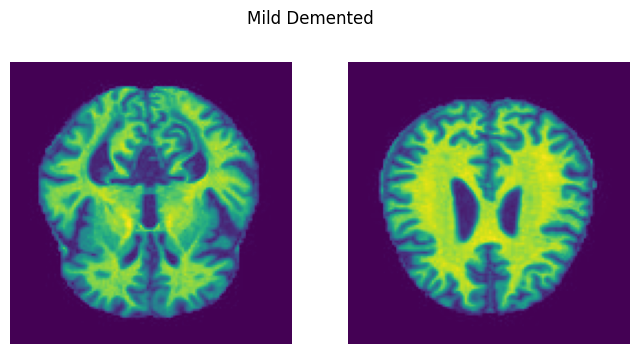

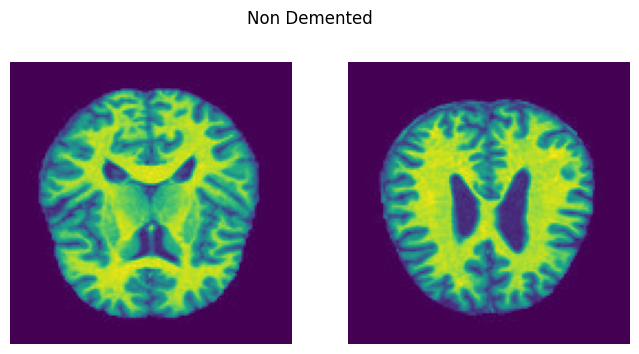

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def read_images_from_path(path, num_images=2):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")][:num_images]
    images = [os.path.join(path, f) for f in image_files]
    return images

def plot_images(images, title):
    plt.figure(figsize=(8, 4))
    for i, image_path in enumerate(images, 1):
        plt.subplot(1, len(images), i)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 각 경로에서 2장씩 이미지를 읽어와서 그림
images_Mild_Demented = read_images_from_path(path_Mild_Demented, num_images=2)
plot_images(images_Mild_Demented, title="Mild Demented")


images_Non_Demented = read_images_from_path(path_Non_Demented, num_images=2)
plot_images(images_Non_Demented, title="Non Demented")



### 이미지 넘파이 배열로 변환

In [6]:
import os
import matplotlib.image as mpimg
import numpy as np

def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) for image_path in images]
    return np.array(image_arrays)

# 각 경로에서 모든 이미지를 읽어와서 numpy 배열로 변환
images_Mild_Demented = read_images_from_path(path_Mild_Demented) # 몇개, 가로, 세로
numpy_array_Mild_Demented = images_to_numpy(images_Mild_Demented)# 몇개, 가로, 세로


images_Non_Demented = read_images_from_path(path_Non_Demented)
numpy_array_Non_Demented = images_to_numpy(images_Non_Demented)


# 넘파이 배열의 크기 확인
print("Mild Demented Shape:", numpy_array_Mild_Demented.shape)
print("Non Demented Shape:", numpy_array_Non_Demented.shape)

Mild Demented Shape: (627, 128, 128)
Non Demented Shape: (2240, 128, 128)


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import Callback
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from sklearn import mixture
from sklearn.cluster import KMeans
import math
import scipy
import time

### 원하는 군집 이미지 선택

In [ ]:
# 정상 = numpy_array_Non_Demented
# 경증 = numpy_array_Mild_Demented

choose_cluster = numpy_array_Non_Demented

### 모델 학습 핵심 하이퍼파라미터 선택

In [ ]:
epochs = 1000
batch_size = 32
alpha = 0.1
gamma = 18

### 생성할 이미지의 갯수 정하기

In [ ]:
# 숫자
# 정상의 배수 = images_Non_Demented * ...
# 경증의 배수 = images_Mild_Demented * ...

make_image = (len(images_Non_Demented) * 2)

batch_size_images = 100 # 한번에 생성할 갯수 -> 100개씩 생성해라.


### GAN 이미지 학습

In [18]:
X_data = np.reshape(choose_cluster, (-1,128,128,1))

In [19]:
print(np.max(X_data), np.min(X_data))

255 0


In [20]:
X_data = X_data / 255.
print(np.max(X_data), np.min(X_data))

1.0 0.0


In [21]:
X_data = np.reshape(X_data, (-1,128*128))
print(np.shape(X_data))

(2240, 16384)


In [22]:
X_data = (X_data - 0.5) * 2.0

class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.dense1 = layers.Dense(500, activation='relu')
        self.dense2 = layers.Dense(500, activation='relu')
        self.dense3 = layers.Dense(2000, activation='relu')
        self.fc_mean = layers.Dense(256)
        self.fc_logvar = layers.Dense(256)
        
    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
    def call(self, x):
        out = self.dense1(x)
        out = self.dense2(x)
        out = self.dense3(x)
        mean = self.fc_mean(out)
        logvar = self.fc_logvar(out)
        z = self.sampling((mean, logvar))
        
        return mean, logvar, z

class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(2000, activation='relu')
        self.dense2 = layers.Dense(500, activation='relu')
        self.dense3 = layers.Dense(500, activation='relu')
        self.output_layer = layers.Dense(128*128, activation='tanh')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.output_layer(x)
        
        return x

class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dense1 = layers.Dense(2000, activation='relu')
        self.dense2 = layers.Dense(500, activation='relu')
        self.dense3 = layers.Dense(500, activation='relu')
        self.fc2 = layers.Dense(1)
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        xl = x
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x, xl

In [23]:
# Training loop
epochs = epochs
alpha = alpha
gamma = gamma

# Create a TensorFlow Dataset from the data
dataset = tf.data.Dataset.from_tensor_slices(X_data)

# Define batch size
batch_size = batch_size

# Batch the dataset
dataset = dataset.batch(batch_size)

# Initialize models
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

# Define the optimizers
encoder_optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-4)
decoder_optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=3e-4*alpha)

encoder.compile(optimizer='adam', loss='mse')
decoder.compile(optimizer='adam', loss='mse')
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

In [24]:
st = time.time()
for epoch in range(epochs):
    # Iterate over the batches
    for i, batch in enumerate(dataset):
        # Extract data from the batch
        data = batch
        bs = data.shape[0]

        ones_label = tf.ones((bs, 1))
        zeros_label = tf.zeros((bs, 1))
        zeros_label1 = tf.zeros((bs, 1))

        with tf.GradientTape(persistent=True) as tape:
            mean, logvar, z = encoder(data)
            x_tilda = decoder(z)

            output = discriminator(data)[0]
            errD_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(ones_label, output))

            output = discriminator(x_tilda)[0]
            errD_rec_enc = tf.reduce_mean(tf.keras.losses.binary_crossentropy(zeros_label, output))

            output = discriminator(decoder(tf.random.normal((bs, 256))))[0]
            errD_rec_noise = tf.reduce_mean(tf.keras.losses.binary_crossentropy(zeros_label1, output))

            gan_loss = errD_real + errD_rec_enc + errD_rec_noise

            x_l_tilda = discriminator(x_tilda)[1]
            x_l = discriminator(data)[1]
            rec_loss = tf.reduce_mean(tf.square(x_l_tilda - x_l))
            err_dec = gamma * rec_loss - gan_loss

            prior_loss = 1 + logvar - tf.square(mean) - tf.exp(logvar)
            prior_loss = (-0.5 * tf.reduce_sum(prior_loss)) / tf.cast(tf.size(mean), dtype=prior_loss.dtype)
            err_enc = 0.05  * prior_loss + 5 * rec_loss
            

        encoder_gradients = tape.gradient(err_enc, encoder.trainable_variables)
        decoder_gradients = tape.gradient(err_dec, decoder.trainable_variables)
        discriminator_gradients = tape.gradient(gan_loss, discriminator.trainable_variables)

        encoder_optimizer.apply_gradients(zip(encoder_gradients, encoder.trainable_variables))
        decoder_optimizer.apply_gradients(zip(decoder_gradients, decoder.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        
et = time.time() - st
print("총 학습 시간 : ", et)

총 학습 시간 :  956.4803564548492


In [ ]:
# Save the models in TensorFlow SavedModel format
encoder.save('GAN_Non_e1000_encoder')
decoder.save('GAN_Non_e1000_decoder')
discriminator.save('GAN_Non_e1000_discriminator')

# # Alternatively, save the models in HDF5 format
# encoder.save('GAN_Non_e1000_encoder.h5', save_format='h5')
# decoder.save('GAN_Non_e1000_decoder.h5', save_format='h5')
# discriminator.save('GAN_Non_e1000_discriminator.h5', save_format='h5')


### GAN 이미지 생성 저장

In [25]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img

# 이미지를 저장할 디렉토리 경로 설정
save_dir = "./MRI_치매_데이터__생성_new/GAN_Non_e1000_random-vector_1"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 잠재 공간의 차원 설정
latent_dim = 256  # 생성자의 입력 차원에 맞게 조정

# 이미지 생성 및 저장을 위한 배치 처리
batch_size_images = batch_size_images  # 한 번에 처리할 이미지 수
make_image = make_image  # 총 생성할 이미지 수

# 잠재 공간에서 무작위 벡터 생성
for i in range(0, n_images, batch_size):
    # 배치 크기만큼 무작위 잠재 벡터 생성
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 생성자를 사용하여 배치 이미지 생성
    generated_images = decoder.predict(random_latent_vectors)

    for j, generated_image in enumerate(generated_images):
        # 생성된 이미지를 128x128 크기로 변환
        generated_image = generated_image.reshape((128, 128, 1))

        # 이미지 배열을 이미지로 변환
        img = array_to_img(generated_image * 255.0, scale=False)

        # 이미지 파일 저장
        img.save(os.path.join(save_dir, f"generated_image_{i+j+1}.jpg"))

    # 진행 상태 메시지 출력
    print(f"{i+batch_size if i+batch_size < n_images else n_images}개의 이미지 생성 및 저장 완료.")

print(f"총 {n_images}개의 이미지 생성 및 저장 완료.")


4/4 [==============================] - 0s 3ms/step
100개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 4ms/step
200개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 3ms/step
300개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 3ms/step
400개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 3ms/step
500개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 3ms/step
600개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 3ms/step
700개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 3ms/step
800개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 4ms/step
900개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 3ms/step
1000개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 3ms/step
1100개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 3ms/step
1200개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 3ms/step
1300개의 이미지 생성 및 저장 완료.
4/4 [==============================] - 0s 3ms/s